# 프로젝트명: XAI(eXplanable AI) 실습 2 (SHapley Additive exPlanation - SHAP)

#### 📌 PDP와는 다르게, 변수 간 관계(의존성)까지 고려해서 모델영향력을 계산합니다. (개별 데이터에 대하여) 
- PDP - 전역적, SHAP - 지역적 
- SHAP의 단점은 데이터가 많아지면 계산량이 많아지고, 새로운 이상치의 등장에 약합니다. 

#### 🚨 주의사항
- XAI 기법은 모델의 예측값을 설명하기 위한 것이므로, 현상 자체를 설명하는 것이 아닙니다. (물리법칙, 타 도메인 법칙들)
- 원인과 결과를 나타내는 인과추론이 아니라, 상관관계에 가깝기 때문에 인과추론을 위해선 해당 도메인 지식이 반드시 필요합니다.

### 1. 일반적인 모델 결과 해석방법 (선형회귀모델)

#### 실습 데이터 : 보스턴 부동산 데이터셋

- [X] CRIM: 도시별 범죄발생률
- [X] ZN: 25,000평을 넘는 토지의 비율
- [X] INDUS: 도시별 비상업 지구의 비유
- [X] CHAS: 찰스 강의 더미 변수(1 = 강의 경계, 0 = 나머지)
- [X] NOX: 일산화질소 농도
- [X] RM: 주거할 수 있는 평균 방의개수
- [X] AGE: 1940년 이전에 지어진 주택의 비율
- [X] DIS: 5개의 고용지원센터까지의 가중치가 고려된 거리
- [X] RAD: 고속도로의 접근 용이성에 대한 지표
- [X] TAX: 10,000달러당 재산세 비율
- [X] PTRATIO: 도시별 교사와 학생의 비율
- [X] B: 도시의 흑인 거주 비유
- [X] LSTAT: 저소득층의 비율
- [Y] MEDV: 본인 소유 주택 가격의 중앙값

In [1]:
import warnings
warnings.filterwarnings('ignore')

import shap 
from sklearn.model_selection import train_test_split
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 보스턴 데이터
data = pd.read_csv("https://blog.kakaocdn.net/dn/xjHHl/btsvj90VSNh/Pjhm2ucmtqgEuXqjnrV2q0/boston_data.csv?attach=1&knm=tfile.csv")
df = data[data.columns[:-1]]
X = df
X_features = X.columns[:-1]

y = data['MEDV']



In [2]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[X_features], df['MEDV'], test_size=0.2, random_state=1)

In [5]:
X_train.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
42,0.14150,0.0,6.91,0,0.448,6.169,6.6,5.7209,3,233,17.9,383.37,5.81
58,0.15445,25.0,5.13,0,0.453,6.145,29.2,7.8148,8,284,19.7,390.68,6.86
385,16.81180,0.0,18.10,0,0.700,5.277,98.1,1.4261,24,666,20.2,396.90,30.81
78,0.05646,0.0,12.83,0,0.437,6.232,53.7,5.0141,5,398,18.7,386.40,12.34
424,8.79212,0.0,18.10,0,0.584,5.565,70.6,2.0635,24,666,20.2,3.65,17.16
160,1.27346,0.0,19.58,1,0.605,6.250,92.6,1.7984,5,403,14.7,338.92,5.50
185,0.06047,0.0,2.46,0,0.488,6.153,68.8,3.2797,3,193,17.8,387.11,13.15
101,0.11432,0.0,8.56,0,0.520,6.781,71.3,2.8561,5,384,20.9,395.58,7.67
268,0.54050,20.0,3.97,0,0.575,7.470,52.6,2.8720,5,264,13.0,390.30,3.16
173,0.09178,0.0,4.05,0,0.510,6.416,84.1,2.6463,5,296,16.6,395.50,9.04


Text(0, 0.5, 'MEDV\n (/1000$)')

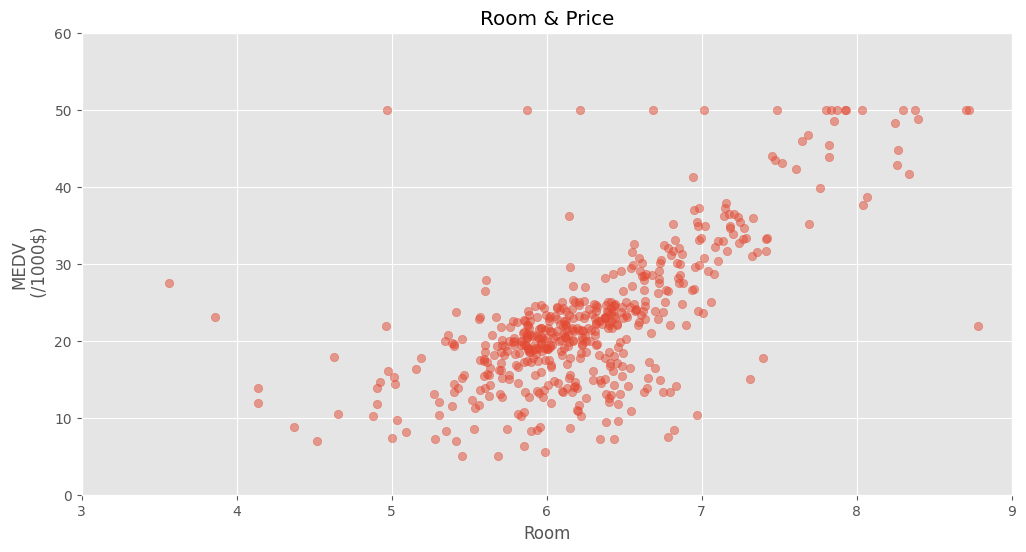

In [3]:
## 방의 갯수와 집값 산점도
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

fig, ax1 = plt.subplots(1,1, figsize=(12,6))
ax1.scatter(X['RM'], y, alpha=0.5)

ax1.set_title("Room & Price")
ax1.set_xlim(3, 9)
ax1.set_xlabel("Room")

ax1.set_ylim(0, 60)
ax1.set_ylabel("Price")
ax1.set_ylabel("MEDV\n (/1000$)")



### ✅ 인사이트 발견!
- 방의 갯수가 증가하면 집값도 증가하는 양의 상관관계다. 
- 어떤 집은 방이 많아도 가격이 낮다. (⭐️ 이상치일까? 무엇 때문일까?)


### 1. 선형모델로 방 갯수와 주택 가격 관계 시각화
- 방의 갯수와 집값과의 관계를 확인하기 위해 단일변수(방갯수)로 선형회귀모델 진행
> 집값 = a * (방의 갯수) + b

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np

linear_regression = linear_model.LinearRegression() ## 선형회귀 모델 생성
linear_regression.fit(X_train[['RM']], y_train) ## 학습

pred = linear_regression.predict(X_test[['RM']]) ## 예측
rmse = np.sqrt(mean_squared_error(y_test, pred)) ## RMSE 계산

## 집값 = a * (방의 갯수) + b
a = round(linear_regression.coef_[0], 2) ## a는 기울기(회귀계수)
b = round(linear_regression.intercept_,2) ## b는 절편
print("a : ", a, "\nb : ", b )
print("집값 = %.2f * (방의 갯수) + %.2f" % (a, b))
print("RMSE : %.2f" % rmse)


a :  8.76 
b :  -32.4
집값 = 8.76 * (방의 갯수) + -32.40
RMSE : 6.38


#### 방의 갯수가 달라질때 집값 예측 그래프 시각화 (Train셋 vs Test셋 비교)

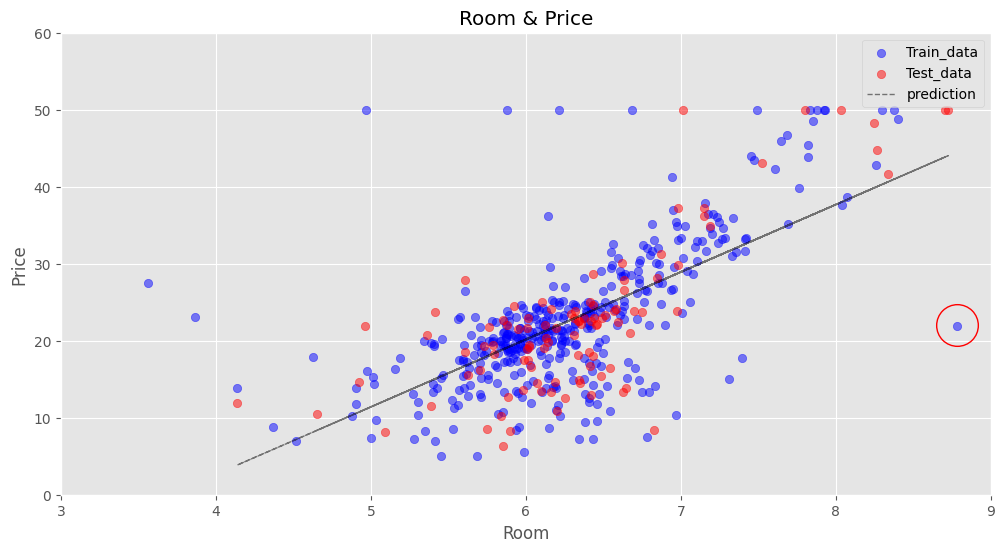

In [7]:
## 시각화
fig, ax1 = plt.subplots(1,1, figsize=(12,6))
ax1.scatter(X_train['RM'], y_train, alpha=0.5, color='blue', label='Train_data')
ax1.scatter(X_test['RM'], y_test, alpha=0.5, color='red', label='Test_data')

ax1.set_title("Room & Price")
ax1.set_xlim(3, 9)
ax1.set_xlabel("Room")
ax1.set_ylim(0, 60)
ax1.set_ylabel("Price")

ax1.plot(
    X_test['RM'], pred, color='black', linewidth=1, label='prediction', linestyle='--', alpha=0.5
)

x_coord = 8.78
y_coord = 22
# 특정 좌표에 빨간색 점선 원형 추가
ax1.plot(x_coord, y_coord, marker='o',
          markersize=30, color='red', 
          linestyle='--', 
          fillstyle='none')


ax1.legend()

##### 방의 갯수 하나만으로 만든 회귀모델의 RMSE가 6.38이면 좋은건가? 나쁜건가?
### 2. 모든 변수를 이용해 집값 예측 (XGBRegressor)
- 왜, 방이 9개이면서 가격은 저렴한 집은 뭘까?

In [8]:
import xgboost 

model = xgboost.XGBRegressor(random_state=0)
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("RMSE", round(rmse,2))


RMSE 3.01


#### 방의 갯수로만 (단일변수)로만 만든 모델보다 RMSE가 더 낮으므로 모든 변수를 넣고 만든 회귀모델이 더 우수하다.
- 단일변수 모델 RMSE : 6.38
- ✅ 모든변수 모델 RMSE : 3.01

### 우수한 성능의 ML모델이 만들어져도, 왜 집값이 높은지, 낮은지 알 수 없습니다.

# ⭐️ SHAP(Shapley Value - 섀플리 값)

### SHAP 란?
> 게임이론으로 모델이 특정 예측을 만들기 위해 각 변수가 얼마나 기여하는지를 이해하는 방법입니다.
- 
> 게임 이론에서 영감을 받아, 변수(feature)를 '플레이어'로 간주하고, 변수가 예측에 기여하는 정도를 '게임에서 참여자가 게임의 결과에 기여하는 정도'로 해석합니다.

1. 개별 데이터가 왜 이런 예측값이 나왔는지, 변수가 어떻게 작용했는지 알 수 있습니다.
2. PDP와는 다르게 변수간 상호작용을 알아볼 수 있습니다.

## 1. SHAP 실습


In [9]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model) ## 모델을 shap에 입력
shap_values = explainer.shap_values(X_train) ## shap value 계산


##### 📌 force_plot : 개별 데이터에 대한 SHAP 값을 시각화합니다. (특정 데이터 하나에 대한 섀플리 영향력을 직관적으로 알려줍니다.)

In [21]:
idx = 0 
X_train_index = X_train.iloc[idx, :].name
X.loc[X_train_index]

CRIM         0.1415
ZN           0.0000
INDUS        6.9100
CHAS         0.0000
NOX          0.4480
RM           6.1690
AGE          6.6000
DIS          5.7209
RAD          3.0000
TAX        233.0000
PTRATIO     17.9000
B          383.3700
LSTAT        5.8100
MEDV        25.3000
Name: 42, dtype: float64

In [20]:
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_train.iloc[idx,:]
)


#### 해석방법

> - 0번째 데이터의 집값은 25.25로 추정됩니다. 
> - 집값의 긍정적인(양의 방향)으로 가장 영향을 준건, LSTAT(하위계층)가 가장 큽니다. 
> - 집값의 부정적인(음의 방향)으로 가장 영향을 준건, RM(방의 갯수)입니다. 

- => 비슷한 조건의 주택에 비해 방의 갯수가 상대적으로 적어서 그렇다고 해석할 수 있습니다.


#### 방이 5개인데 집값이 비싼 데이터 탐색

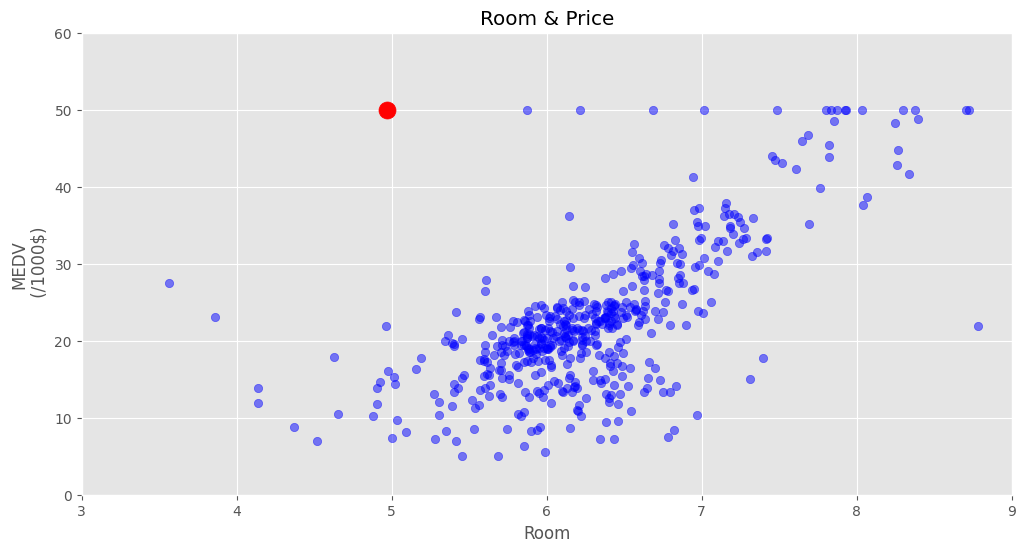

In [10]:
## 방이 5개 인데, 집값이 가장 비싼 데이터
idx = 259
fig, ax1 = plt.subplots(1,1, figsize=(12,6))
ax1.scatter(X['RM'], y, alpha=0.5, color='blue')
ax1.scatter(X_train.iloc[idx]['RM'], y_train.iloc[idx], color='red', s=150)

ax1.set_title("Room & Price")
ax1.set_xlim(3, 9)
ax1.set_xlabel("Room")

ax1.set_ylim(0, 60)
ax1.set_ylabel("Price")
ax1.set_ylabel("MEDV\n (/1000$)")

plt.show()

In [25]:
X_train_index = X_train.iloc[idx, :].name
X.loc[X_train_index]

CRIM         4.89822
ZN           0.00000
INDUS       18.10000
CHAS         0.00000
NOX          0.63100
RM           4.97000
AGE        100.00000
DIS          1.33250
RAD         24.00000
TAX        666.00000
PTRATIO     20.20000
B          375.52000
LSTAT        3.26000
MEDV        50.00000
Name: 368, dtype: float64

In [11]:
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_train.iloc[idx,:]
)


#### 해석방법

> - 259번째 데이터의 집값은 49.99로 추정됩니다. 
> - 이 데이터에선 RM(방의 갯수)는 그다지 집값에 영향을 주지 않습니다.
> - 집값의 긍정적인(양의 방향)으로 가장 영향을 준건, DIS(업무지와의 거리가 가까움)가 가장 큽니다. 
> - 집값의 긍정적인(양의 방향)으로 두번째로 영향을 준건, LSTAT(하위계층)이 낮으므로 집값에 긍정적인 영향을 끼쳤다고 볼 수 있습니다.

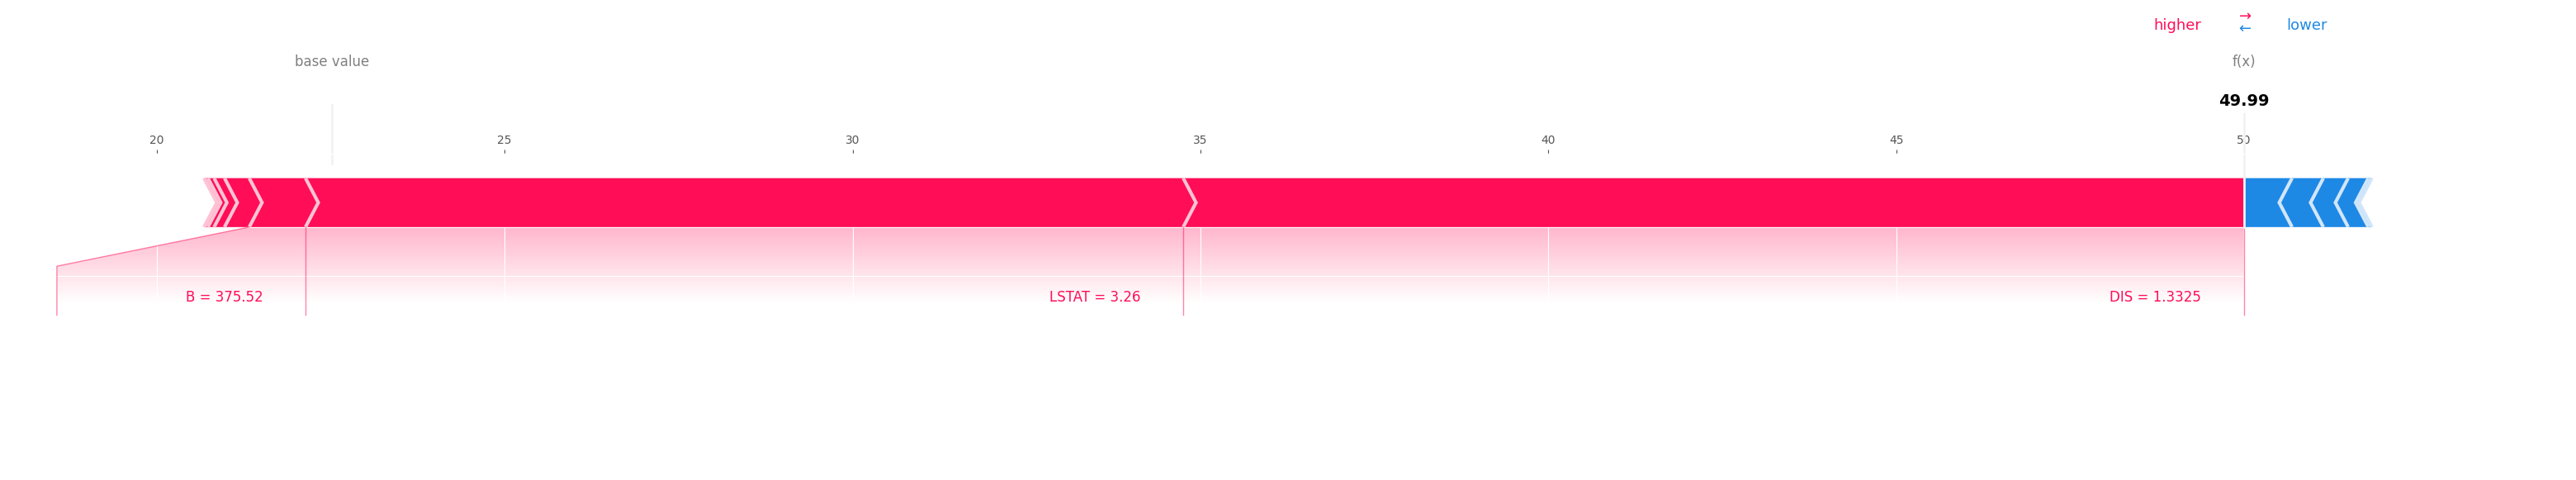

In [26]:

shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_train.iloc[idx,:],
    matplotlib=True,
    show=False
)

plt.gca().set_facecolor('white')
plt.gcf().set_size_inches(40, 5)
plt.show()

### 📌 전체 데이터를 섀플리로 확인하기 (똑같은 force_plot)

In [27]:
shap.force_plot(
    explainer.expected_value,
    shap_values,
    X_train,
)


- 클릭을 하면, 해당하는 index 값을 찾을 수 있습니다.

In [12]:
idx = 96 
X_train_index = X_train.iloc[idx, :].name
X.loc[X_train_index]

CRIM         0.05602
ZN           0.00000
INDUS        2.46000
CHAS         0.00000
NOX          0.48800
RM           7.83100
AGE         53.60000
DIS          3.19920
RAD          3.00000
TAX        193.00000
PTRATIO     17.80000
B          392.63000
LSTAT        4.45000
MEDV        50.00000
Name: 186, dtype: float64

#### 📌 전체 데이터를 확인하는 force_plot에서 12시 방향에서 개별 변수를 필터링할 수 있습니다.
- CRIM(범죄율)로 필터링을 걸었으면, 

#### 해석방법

> - 새플리값 중 CRIM(범죄율)이 집값에 미치는 영향을 시각화합니다.
> - 전체가 파란색으로 보아, 범죄율이 존재하는한 집값에 음의 상관관계를 기칩니다.
> - 그렇지만, 어떤 집은 범죄율이 집값 하락에 강한 영향력을 미치는 반면, 그다지 적은 영향을 주는 경우도 있습니다.
> - ✅ 즉, `주택 간 범죄율이 똑같더라도` 집값에 영향을 미치는 `영향력은 서로 다를 수 있다`는 의미입니다.

In [29]:
shap.force_plot(
    explainer.expected_value,
    shap_values,
    X_train,
)


In [14]:
idx = 199 
X_train_index = X_train.iloc[idx, :].name
X.loc[X_train_index]

CRIM        73.5341
ZN           0.0000
INDUS       18.1000
CHAS         0.0000
NOX          0.6790
RM           5.9570
AGE        100.0000
DIS          1.8026
RAD         24.0000
TAX        666.0000
PTRATIO     20.2000
B           16.4500
LSTAT       20.6200
MEDV         8.8000
Name: 418, dtype: float64

In [15]:
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_train.iloc[idx,:]
)


##### 📌 summary_plot : 전체 변수들이 섀플리 값 결정에 어떻게 영향을 끼치는지 시각화

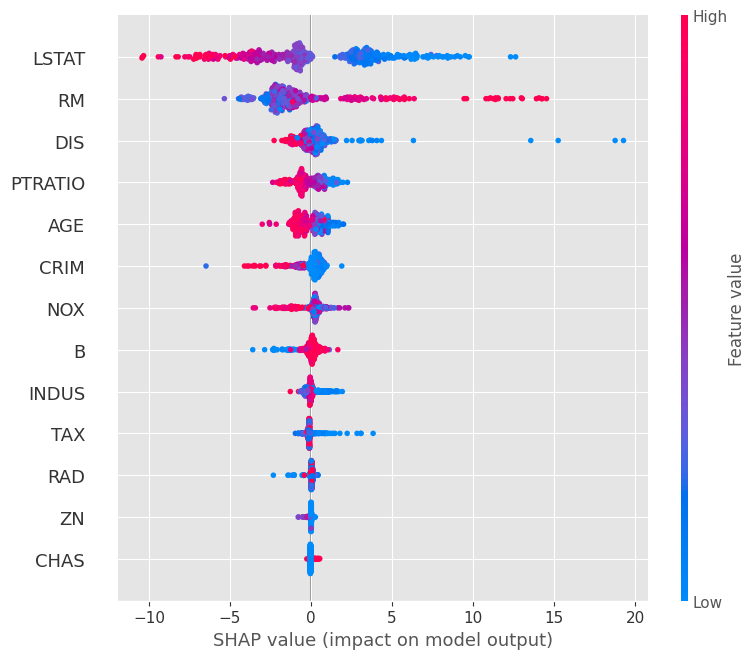

In [35]:
## summary_plot은 모든 변수의 섀플리 값을 보여준다. 
shap.summary_plot(shap_values, X_train)

#### 해석방법

> - X축은 섀플리 값을 의미하며, 왼쪽으로 갈수록 예측값을 감소, 오른쪽으로 갈수록 예측값을 증가에 영향을 주었다고 해석하면 됩니다.
> - 붉은색은 해당 변수가 높은 것을 의미하고, 파란색은 해당 변수가 낮은 것을 의미합니다.
> - LSTAT(하위계층)의 수치가 높을 수록 집값 `감소`에 영향을 주며, 수치가 높을 수록 집값 `증가`에 영향을 줍니다.
> - RM(방의 갯수)의 수치가 높을 수록 집값 `증가`에 영향을 주며, 낮을수록 집값 `감소`에 영향을 줍니다. 

#### 📌 TIP
> - 좌우로 분포가 넓을 수록 해석하기 용이하고, 분포가 짧다면 해석하기 힘듭니다.
> - 상위에 변수가 좌우 분포가 넓은 변수들 위주로 연구해보는게 좋습니다.
> - XAI 방법론은 인과관계가 아니라, 상관관계 기반입니다.
> - RM을 보시면 방이 많아도 집값 감소에 영향을 주는 곳도 있습니다. 집값을 예측하는데, 모델이 각 데이터마다 개별적으로 계산하기 때문입니다.
> - 예를 들어, 범죄율이 높고 하위계층도 많은 곳에서 RM이 많으면 관리가 어려워 집값이 낮을 수도 있기 떄문입니다.

In [37]:
X[X['RM'] > 8.7]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
225,0.52693,0.0,6.20,0,0.504,8.725,83.0,2.8944,8,307,17.4,382.00,4.63,50.0
257,0.61154,20.0,3.97,0,0.647,8.704,86.9,1.8010,5,264,13.0,389.70,5.12,50.0
364,3.47428,0.0,18.10,1,0.718,8.780,82.9,1.9047,24,666,20.2,354.55,5.29,21.9


# SHAP의 사용법

### 장점.

1. 데이터 비전문가들도 시각화된 내용을 보고 이해하기 편합니다.
2. 어떤 변수가 모델에 어떤 영향을 주는지 확인할 수 있습니다.
3. 개별 데이터가 어떤 영향으로 이런 예측값을 받았는지 확인할 수 있습니다.

### 단점.

1. 데이터가 많을수록 계산량이 많아집니다. (사용하기 어렵다)
2. 데이터간 상호작용이 복잡한 경우, 해석하기 어려워집니다.
3. 모든 XAI 방법이 그렇지만, 인과관계를 알려주는게 아니며 꼭 완전하게 연구하려면 도메인 지식이 필요합니다.